In [1]:
import os
import tarfile
import gzip
import shutil
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

# comment out this line after combined df_is loaded into the file to avoide reloading it
# combined_df = None

The following are process to extract data from the tar.gz file and store a csv file locally, it will also automatically create a new data frame called combined df.

In [2]:
# Only run extraction/decompression if combined_weather_data.csv does not exist
force_read_from_path = False
if force_read_from_path or not os.path.exists("combined_weather_data.csv"):
    tar_path = "WMO_724000-724999.tar.gz"
    extract_folder = "extracted_files"
    os.makedirs(extract_folder, exist_ok=True)

    print("Extracting tar.gz archive...")
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=extract_folder)
    print("Extraction complete.\n")

    print("Decompressing .nc.gz files...")
    for file in os.listdir(extract_folder):
        if file.endswith(".nc.gz"):
            gz_file_path = os.path.join(extract_folder, file)
            nc_file_path = os.path.join(extract_folder, file[:-3])
            try:
                if os.path.exists(nc_file_path):
                    try:
                        os.remove(nc_file_path)
                    except PermissionError:
                        print(f"Cannot remove existing file {nc_file_path} - file may be in use.")
                        continue

                with gzip.open(gz_file_path, "rb") as f_in, open(nc_file_path, "wb") as f_out:
                    shutil.copyfileobj(f_in, f_out)
                print(f"Decompressed {file} to {os.path.basename(nc_file_path)}")
            except PermissionError as e:
                print(f"Permission error with {file}: {str(e)}.")
            except Exception as e:
                print(f"Error processing {file}: {str(e)}")

    print("\nDecompression complete.\n")
    # ----- Step 3: Inspect available columns in one sample file -----
    sample_nc_file = None
    for file in os.listdir(extract_folder):
        if file.endswith(".nc"):
            sample_nc_file = os.path.join(extract_folder, file)
            break

    if sample_nc_file:
        print("Opening sample file for inspection:", sample_nc_file)
        ds = xr.open_dataset(sample_nc_file)
        
        print("\nAvailable Data Variables:")
        for var in ds.data_vars:
            print(" -", var)
        
        print("\nAvailable Coordinates:")
        for coord in ds.coords:
            print(" -", coord)
        
        # Export the available columns to a text file
        with open("available_columns.txt", "w") as f:
            f.write("Data Variables:\n")
            for var in ds.data_vars:
                f.write(" - " + var + "\n")
            f.write("\nCoordinates:\n")
            for coord in ds.coords:
                f.write(" - " + coord + "\n")
        print("\nAvailable columns exported to 'available_columns.txt'\n")
    else:
        print("No .nc file found for inspection.\n")
    # List all .nc files in the extract_folder
    nc_files = [os.path.join(extract_folder, f) for f in os.listdir(extract_folder) if f.endswith('.nc')]
    dfs = []

    # List of data variables to extract
    desired_vars = [
        'station_id',         # Station ID
        'temperatures',       # Temperature
        'dewpoints',          # Dew point
        'slp',                # Sea level pressure
        'stnlp',              # Station level pressure
        'windspeeds',         # Wind speed
        'winddirs',           # Wind direction
        'total_cloud_cover',  # Total cloud cover
        'low_cloud_cover',    # Low cloud cover
        'mid_cloud_cover',    # Mid cloud cover
        'high_cloud_cover',   # High cloud cover
        'precip1_depth',      # 1-hour precipitation depth
        'precip2_depth',      # 2-hour precipitation depth
        'precip3_depth',      # 3-hour precipitation depth
        'precip6_depth',      # 6-hour precipitation depth
        'precip9_depth',      # 9-hour precipitation depth
        'precip12_depth',     # 12-hour precipitation depth
        'precip15_depth',     # 15-hour precipitation depth
        'precip18_depth',     # 18-hour precipitation depth
        'precip24_depth',     # 24-hour precipitation depth
        'cloud_base',         # Cloud base height
        'wind_gust',          # Wind gust
        'past_sigwx1',        # Past significant weather phenomena
        'input_station_id'    # Input station ID
    ]

    # List of coordinate variables we want to ensure are included
    coord_vars = ['time', 'latitude', 'longitude', 'elevation']

    print("Processing .nc files and extracting desired variables along with coordinates...")
    for nc_file in nc_files:
        try:
            # Open the netCDF file with xarray
            ds = xr.open_dataset(nc_file, chunks={})
            
            # Filter to only the desired data variables that are present in the current file
            available_vars = [var for var in desired_vars if var in ds.data_vars]
            
            # Check which coordinate variables are available in the dataset
            available_coords = [var for var in coord_vars if var in ds.coords]
            
            if available_vars:
                # Combine the data variables and coordinate variables
                all_vars = available_vars + available_coords
                # Convert the dataset to a DataFrame (this will include the coordinates as columns)
                df = ds[all_vars].to_dataframe().reset_index()
                # Optionally, add a column to record the source file name
                df["source_file"] = os.path.basename(nc_file)
                dfs.append(df)
                print(f"Processed {nc_file} with DataFrame shape {df.shape}")
            else:
                print(f"No desired variables found in {nc_file}")
        except Exception as e:
            print(f"Error processing {nc_file}: {e}")

    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        print("\nCombined DataFrame shape:", combined_df.shape)
    else:
        combined_df = pd.DataFrame()
        print("\nNo DataFrames were loaded.")

    print("\nCombined DataFrame preview:")
    print(combined_df.head())
    # ----- Step 5: Save the DataFrame to a CSV file (if not empty) -----
    if not combined_df.empty:
        output_csv_path = "combined_weather_data.csv"
        combined_df.to_csv(output_csv_path, index=False)
        print(f"\nSaved combined data to {output_csv_path}")
        
        # Generate basic statistics for numerical columns
        print("\nBasic statistics of numerical columns:")
        print(combined_df.describe())
        
        # Check for missing values
        missing_values = combined_df.isnull().sum()
        print("\nMissing values count:")
        print(missing_values)
        
        # If a 'time' column exists, output the time range
        if 'time' in combined_df.columns:
            print("\nTime range in the dataset:")
            print(f"Start: {combined_df['time'].min()}")
            print(f"End: {combined_df['time'].max()}")
    else:
        print("\nNo data was successfully extracted.")
elif combined_df is None:
    print("combined_weather_data.csv exists, skipping these steps. Pulling data from CSV instead.")
    combined_df = pd.read_csv("combined_weather_data.csv")
    print("Data loaded from CSV file.\n")
else:
    print("Data already exists as variable combined_df, for reloading, please reassign combined_df to None.")

Extracting tar.gz archive...
Extraction complete.

Decompressing .nc.gz files...
Decompressed hadisd.3.4.2.202502p_19310101-20250301_724006-03701.nc.gz to hadisd.3.4.2.202502p_19310101-20250301_724006-03701.nc
Decompressed hadisd.3.4.2.202502p_19310101-20250301_724007-03719.nc.gz to hadisd.3.4.2.202502p_19310101-20250301_724007-03719.nc
Decompressed hadisd.3.4.2.202502p_19310101-20250301_724010-13740.nc.gz to hadisd.3.4.2.202502p_19310101-20250301_724010-13740.nc
Decompressed hadisd.3.4.2.202502p_19310101-20250301_724014-93714.nc.gz to hadisd.3.4.2.202502p_19310101-20250301_724014-93714.nc
Decompressed hadisd.3.4.2.202502p_19310101-20250301_724016-93736.nc.gz to hadisd.3.4.2.202502p_19310101-20250301_724016-93736.nc
Decompressed hadisd.3.4.2.202502p_19310101-20250301_724017-03707.nc.gz to hadisd.3.4.2.202502p_19310101-20250301_724017-03707.nc
Decompressed hadisd.3.4.2.202502p_19310101-20250301_724019-93773.nc.gz to hadisd.3.4.2.202502p_19310101-20250301_724019-93773.nc
Decompressed had

In [3]:
print(combined_df.columns.tolist())

['time', 'coordinate_length', 'station_id', 'temperatures', 'dewpoints', 'slp', 'stnlp', 'windspeeds', 'winddirs', 'total_cloud_cover', 'low_cloud_cover', 'mid_cloud_cover', 'high_cloud_cover', 'precip1_depth', 'precip2_depth', 'precip3_depth', 'precip6_depth', 'precip9_depth', 'precip12_depth', 'precip15_depth', 'precip18_depth', 'precip24_depth', 'cloud_base', 'wind_gust', 'past_sigwx1', 'input_station_id', 'latitude', 'longitude', 'elevation', 'source_file']


In [4]:
combined_df.head()

,time,coordinate_length,station_id,temperatures,dewpoints,slp,stnlp,windspeeds,winddirs,total_cloud_cover,...,precip18_depth,precip24_depth,cloud_base,wind_gust,past_sigwx1,input_station_id,latitude,longitude,elevation,source_file
0,2001-01-01 00:00:00,0,b'777777777777',NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,b'724006-99999',36.666,-76.321,6.1,hadisd.3.4.2.202502p_19310101-20250301_724006-...
1,2001-01-01 01:00:00,0,b'777777777777',NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,b'724006-99999',36.666,-76.321,6.1,hadisd.3.4.2.202502p_19310101-20250301_724006-...
2,2001-01-01 02:00:00,0,b'777777777777',NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,b'724006-99999',36.666,-76.321,6.1,hadisd.3.4.2.202502p_19310101-20250301_724006-...
3,2001-01-01 03:00:00,0,b'777777777777',NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,b'724006-99999',36.666,-76.321,6.1,hadisd.3.4.2.202502p_19310101-20250301_724006-...
4,2001-01-01 04:00:00,0,b'777777777777',NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,b'724006-99999',36.666,-76.321,6.1,hadisd.3.4.2.202502p_19310101-20250301_724006-...


Data used as a demo here is aquired from 720000-721999 from the page https://www.metoffice.gov.uk/hadobs/hadisd/v342_202502p/download.html, containing 140 station data

In [5]:
import re

# First cast the byte strings to regular Python strings
combined_df['input_station_id'] = combined_df['input_station_id'].astype(str)

# Extract the first 5 digits from 'input_station_id' and append to the existing 'station' column
combined_df['station'] = combined_df['input_station_id'].str.extract(r'(\d{6})')

In [6]:
# Drop duplicate station entries based on station_id, latitude, and longitude
unique_stations = combined_df[['source_file', 'latitude', 'longitude']].drop_duplicates()

# Calculate the mean latitude and longitude for centering the map
lat_mean = unique_stations['latitude'].mean()
lon_mean = unique_stations['longitude'].mean()

# Create a Folium map centered around the calculated mean coordinates
m = folium.Map(location=[lat_mean, lon_mean], zoom_start=6)

# Create a marker cluster to manage multiple markers
marker_cluster = MarkerCluster().add_to(m)

# Add a marker for each unique station
for _, row in unique_stations.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Station ID: {row['source_file']}<br>Latitude: {row['latitude']}<br>Longitude: {row['longitude']}",
    ).add_to(marker_cluster)

# Save the map to an HTML file (optional)
m.save("station_map.html")

# Display the interactive map in your notebook or browser
m

For analysis of the distribution, we sample 10% of data from each station to make sure that the amount of data is still managable

In [7]:
print(combined_df.shape)
# Sample 10% of the data based on the 'source_file' column
smaller = combined_df.groupby('source_file', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=42)).reset_index(drop=True)

# Display the shape of the smaller DataFrame
print("Smaller DataFrame shape:", smaller.shape)

(93897370, 31)


C:\Users\kaiwe\AppData\Local\Temp\ipykernel_17168\2931834146.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  smaller = combined_df.groupby('source_file', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=42)).reset_index(drop=True)


Smaller DataFrame shape: (9389731, 31)


Here we plot the distribution of temperature excluding the unrealistics values

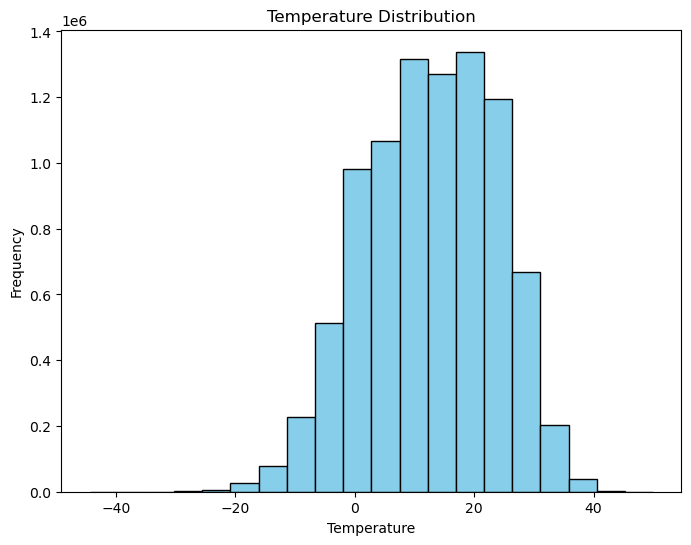

In [8]:
plt.figure(figsize=(8, 6))
temp_data = smaller['temperatures'].dropna()  # Drop missing values
#print("unrrealistic temp values" + temp_data.min())
temp_data = temp_data[temp_data > -273]  # Filter out unrealistic values, I really hope nowhere in the world has temperatures below absolute zero
plt.hist(temp_data, bins=20, color='skyblue', edgecolor='black')
plt.title("Temperature Distribution")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()
temp_data = 0

Then, we perfrom some sanity check to varify if we get any weird data from the plot, we do see that for wind distribution we have a lot of 0 (I assume that is when there is no wind), Also for cloud cover we see that there are many invalid values of -888, which might need to be removed.

In [9]:
def plot_weather_data(df):
    # Set up the figure layout
    fig = plt.figure(figsize=(20, 16))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    # 1. Scatter plot of date vs temperature (no subsample)
    ax1 = plt.subplot(3, 2, 1)
    temp_scatter_data = df.dropna(subset=['time', 'temperatures'])
    temp_scatter_data = temp_scatter_data[temp_scatter_data['temperatures'] > -273]
    sns.scatterplot(x='time', y='temperatures', data=temp_scatter_data, alpha=0.6, s=10, ax=ax1)
    ax1.set_title('Temperature vs Date')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Temperature')
    ax1.grid(True, alpha=0.3)

    # 2. Distribution of temperatures (no subsample)
    ax2 = plt.subplot(3, 2, 2)
    sns.histplot(df[df['temperatures'] > -273]['temperatures'].dropna(), bins=50, kde=True, ax=ax2)
    ax2.set_title('Temperature Distribution')
    ax2.set_xlabel('Temperature')

    # 3. Wind direction distribution (no subsample)
    ax4 = plt.subplot(3, 2, 3, polar=True)
    wind_data = df.dropna(subset=['winddirs'])
    hist, _ = np.histogram(wind_data['winddirs'], bins=16, range=(0, 360))
    width = 2 * np.pi / 16
    ax4.bar(np.deg2rad(np.arange(0, 360, 22.5)), hist, width=width, bottom=0.0)
    ax4.set_title('Wind Direction Distribution')
    ax4.set_theta_zero_location("N")
    ax4.set_theta_direction(-1)

    # 4. Cloud cover distribution (no subsample)
    ax5 = plt.subplot(3, 2, 4)
    sns.countplot(x='total_cloud_cover', data=df, ax=ax5)
    ax5.set_title('Cloud Cover Distribution')
    ax5.set_xlabel('Total Cloud Cover')
    ax5.set_ylabel('Count')

    # 5. Wind speed distribution (no subsample)
    ax6 = plt.subplot(3, 2, 5)
    sns.histplot(df[df['windspeeds'] >= 0]['windspeeds'].dropna(), bins=50, kde=True, ax=ax6)
    ax6.set_title('Wind Speed Distribution')
    ax6.set_xlabel('Wind Speed')

    plt.tight_layout()
    plt.savefig('weather_data_visualization.png', dpi=300)
    plt.show()


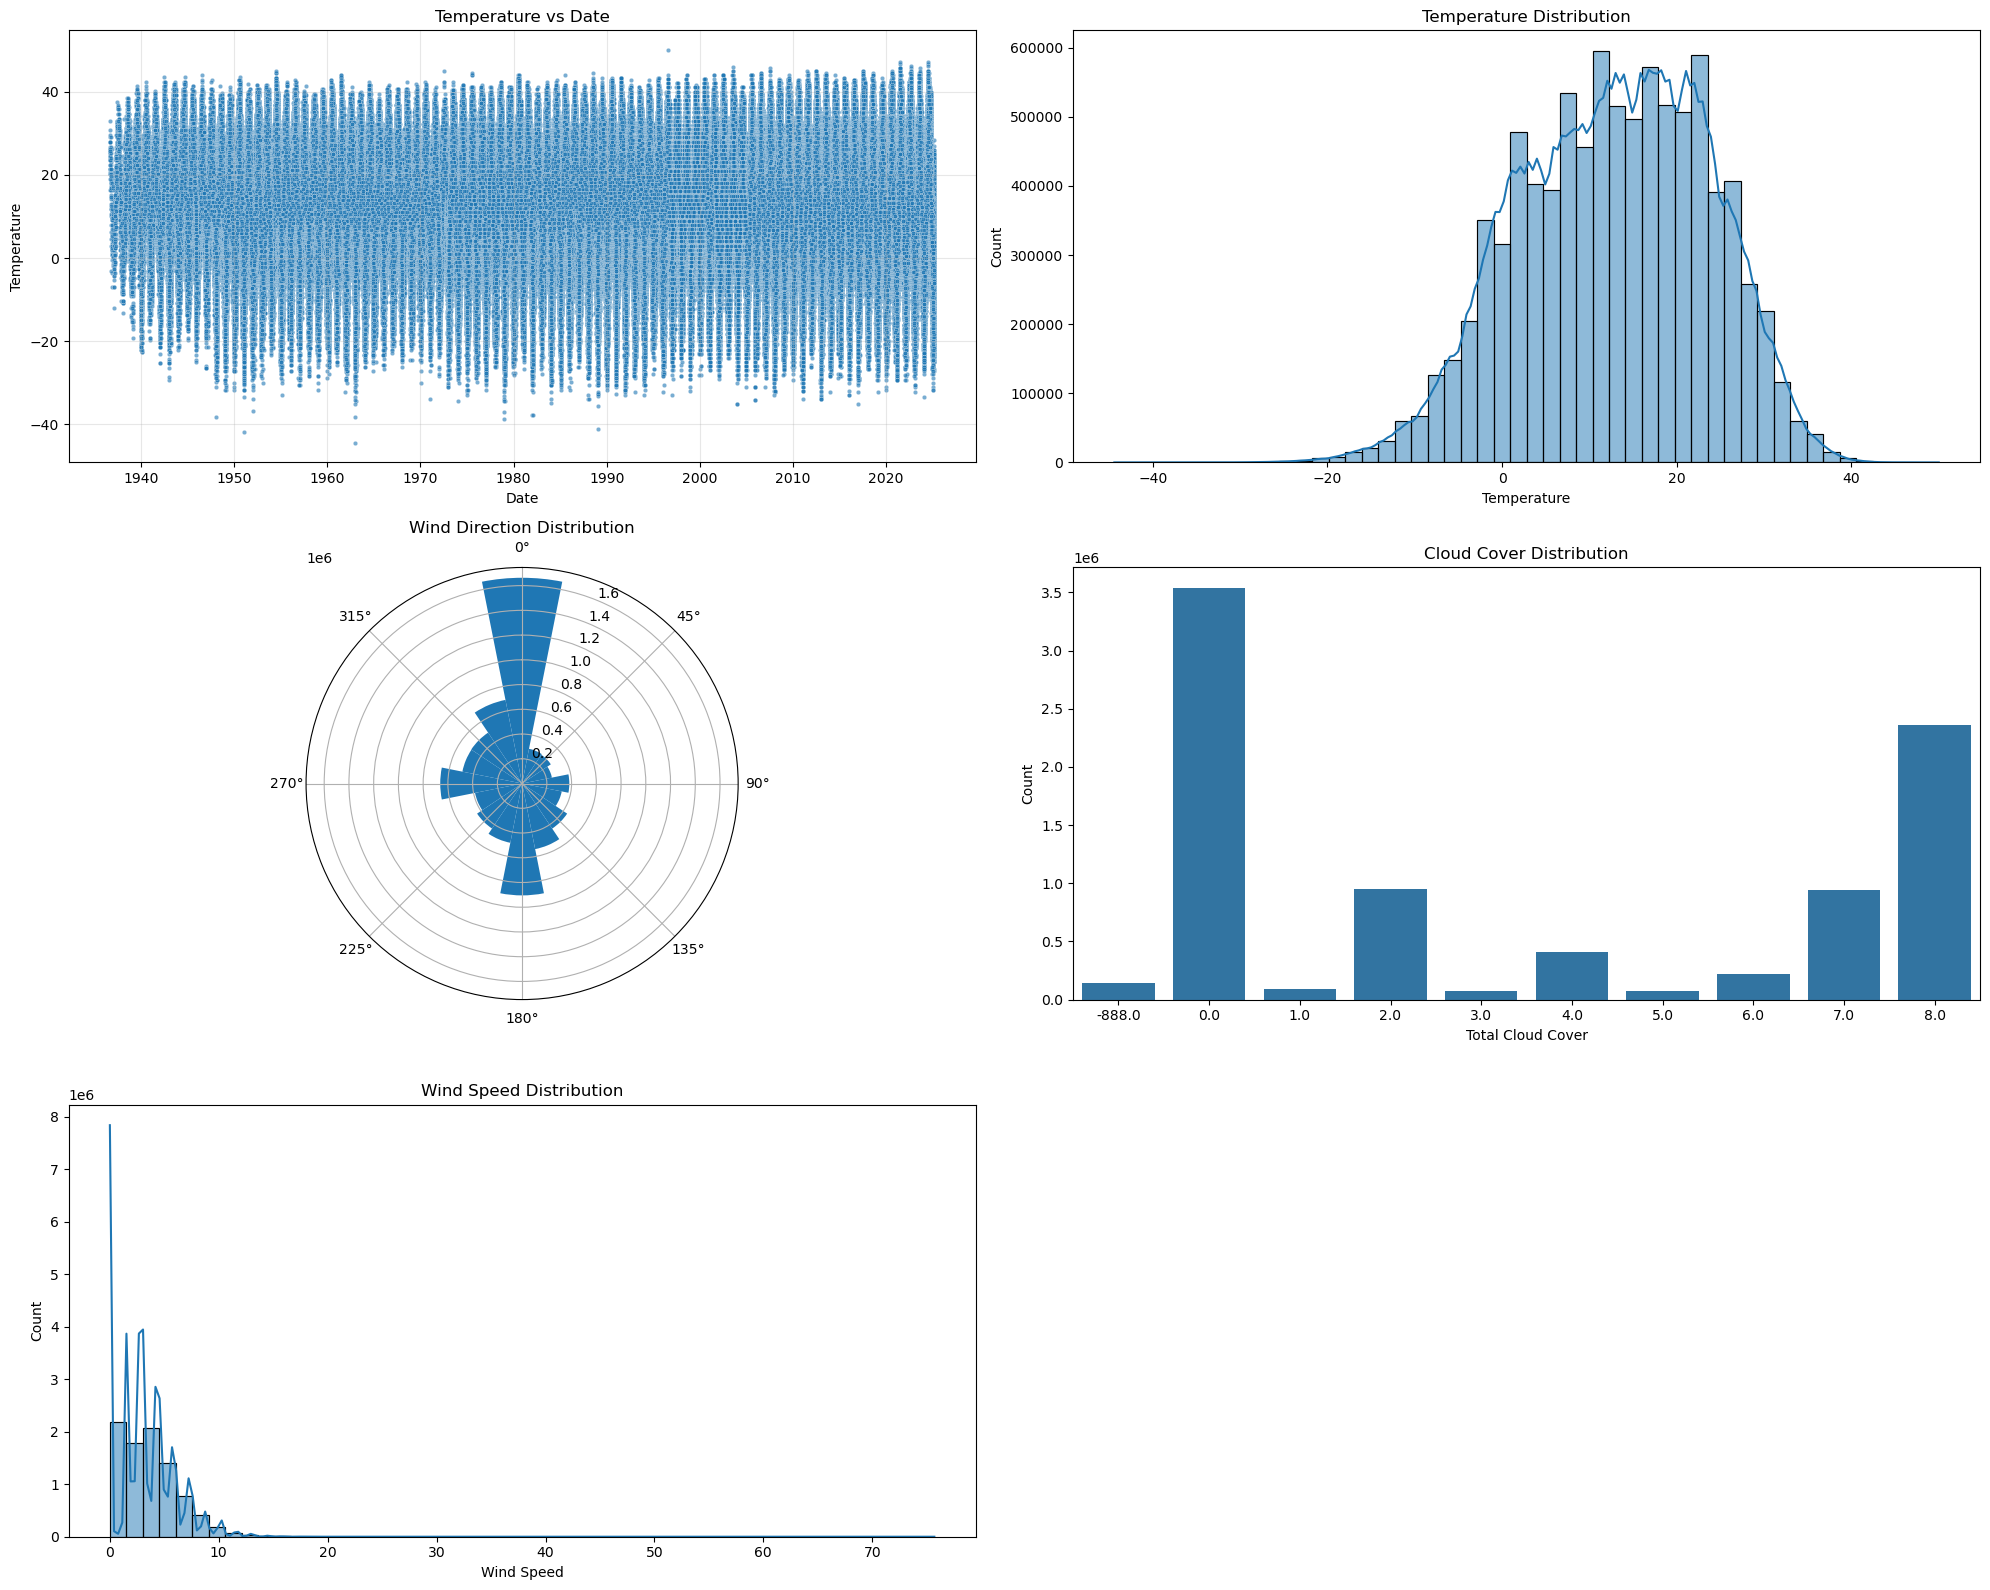

In [10]:
plot_weather_data(smaller)

Same here for some analysis for yearly average temperature, we see that there are some extremely high value for datas before 1940s, this could just because of the bad 

2024
1936
Slope: -0.0005023185123312887
Intercept: 12.80328020255433


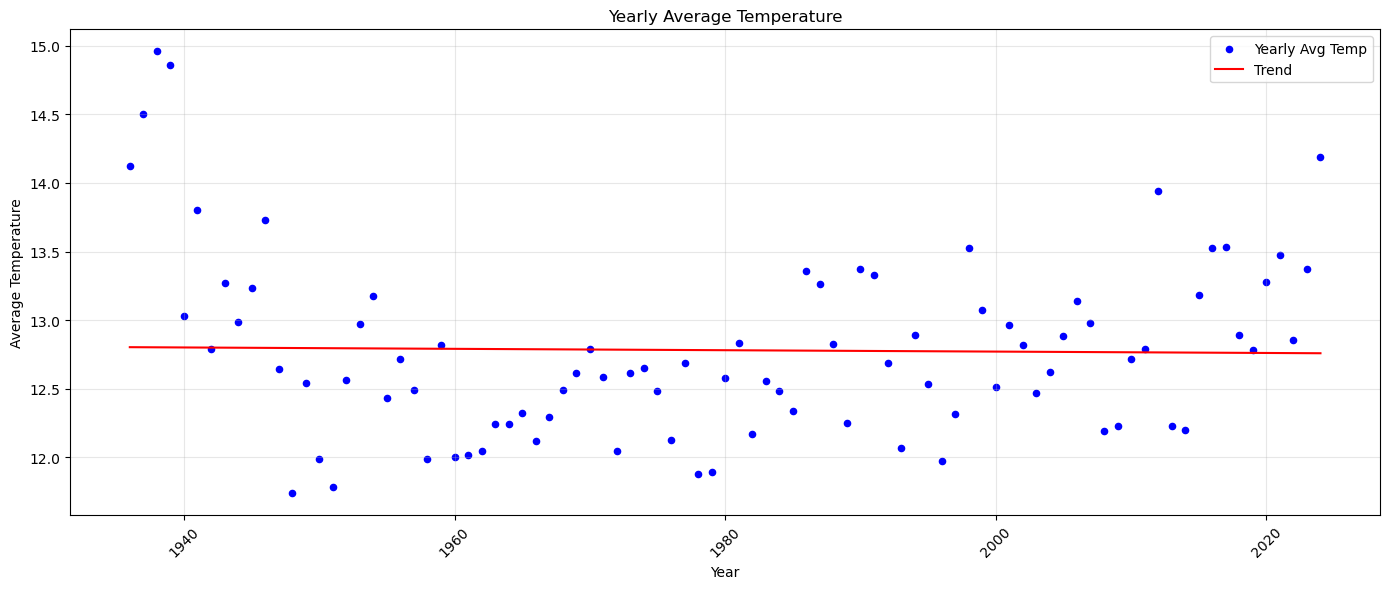

In [11]:
plt.figure(figsize=(14, 6))

# Filter out extreme temperatures
temp_data = smaller[smaller['temperatures'] > -100].copy()

# Extract the year from 'time'
temp_data['year'] = pd.to_datetime(temp_data['time']).dt.year

# Group by year and calculate mean temperature, excluding 2024
yearly_temps = temp_data.groupby('year')['temperatures'].mean().reset_index()
yearly_temps = yearly_temps[yearly_temps['year'] != 2025]
print(yearly_temps['year'].max())
print(yearly_temps['year'].min())

def plot_yearly_temperature_trend(yearly_temps):
    """
    Plots the yearly average temperature trend and saves the plot as an image.

    Parameters:
    yearly_temps (pd.DataFrame): A DataFrame with 'year' and 'temperatures' columns.

    Returns:
    None
    """
    # Scatter plot of yearly average temperature
    plt.scatter(yearly_temps['year'], yearly_temps['temperatures'], color='blue', s=20, label='Yearly Avg Temp')

    # Add a simple linear trend
    z = np.polyfit(np.arange(len(yearly_temps)), yearly_temps['temperatures'], 1)
    p = np.poly1d(z)
    plt.plot(yearly_temps['year'], p(np.arange(len(yearly_temps))), color='red', label='Trend')

    # Print slope and intercept
    print(f"Slope: {z[0]}")
    print(f"Intercept: {z[1]}")

    plt.title('Yearly Average Temperature')
    plt.xlabel('Year')
    plt.ylabel('Average Temperature')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.savefig('yearly_temperature_trend.png', dpi=300)
    plt.show()

# Example usage
plot_yearly_temperature_trend(yearly_temps)


The next plot generates the data when excluded data before 1950

2024
1936
Slope: 0.012053772858837223
Intercept: 12.211473394851803


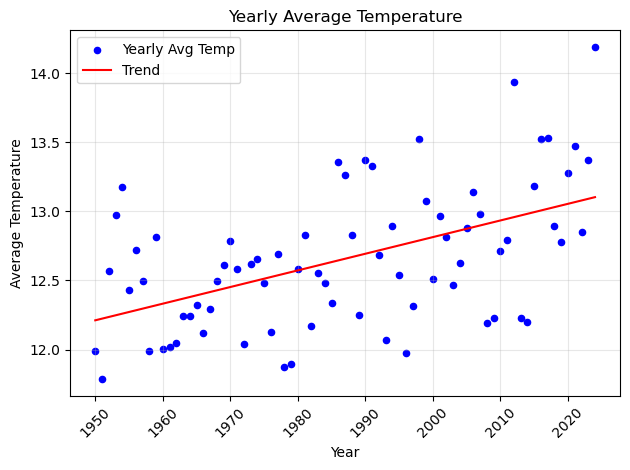

In [12]:
yearly_temps_filtered = temp_data.groupby('year')['temperatures'].mean().reset_index()
yearly_temps_filtered = yearly_temps[yearly_temps['year'] != 2025][yearly_temps['year'] >= 1950]
print(yearly_temps['year'].max())
print(yearly_temps['year'].min())
plot_yearly_temperature_trend(yearly_temps_filtered)

The following will conduct analysis for an individual data points, I will choose the data point that is located in the SFO here, we can find from the map

In [13]:
SFO = combined_df[combined_df['source_file'] == 'hadisd.3.4.2.202502p_19310101-20250301_724940-23234.nc']

In [14]:
print(SFO.describe())
SFO.head(10)

                                time  coordinate_length  temperatures  \
count                         654843           654843.0  6.544090e+05   
mean   1987-01-27 19:00:40.373646976                0.0 -3.902758e+27   
min              1948-01-01 14:00:00                0.0 -2.000000e+30   
25%              1966-09-05 03:30:00                0.0  1.110000e+01   
50%              1987-10-22 09:00:00                0.0  1.330000e+01   
75%              2006-06-25 15:30:00                0.0  1.610000e+01   
max              2025-02-28 23:00:00                0.0  4.000000e+01   
std                              NaN                0.0  8.826266e+28   

          dewpoints           slp         stnlp    windspeeds       winddirs  \
count  6.542620e+05  6.535390e+05  6.141710e+05  6.544280e+05  652276.000000   
mean  -1.525383e+27 -2.693030e+26 -8.531175e+28 -2.200395e+26     195.841303   
min   -2.000000e+30 -2.000000e+30 -2.000000e+30 -2.000000e+30    -888.000000   
25%    6.700000e+00  1

,time,coordinate_length,station_id,temperatures,dewpoints,slp,stnlp,windspeeds,winddirs,total_cloud_cover,...,precip24_depth,cloud_base,wind_gust,past_sigwx1,input_station_id,latitude,longitude,elevation,source_file,station
90662653,1948-01-01 14:00:00,0,b'777777777777',8.3,6.1,1021.3,1020.7,1.5,113.0,8.0,...,NaN,732.0,NaN,NaN,999999-23234,37.62,-122.366,3.2,hadisd.3.4.2.202502p_19310101-20250301_724940-...,999999
90662654,1948-01-01 15:00:00,0,b'777777777777',7.8,6.7,1022.0,1021.3,0.0,0.0,8.0,...,NaN,610.0,NaN,NaN,999999-23234,37.62,-122.366,3.2,hadisd.3.4.2.202502p_19310101-20250301_724940-...,999999
90662655,1948-01-01 16:00:00,0,b'777777777777',8.9,5.6,1022.4,1021.7,1.0,360.0,8.0,...,NaN,549.0,NaN,NaN,999999-23234,37.62,-122.366,3.2,hadisd.3.4.2.202502p_19310101-20250301_724940-...,999999
90662656,1948-01-01 17:00:00,0,b'777777777777',8.9,6.1,1022.7,1022.0,1.0,45.0,8.0,...,NaN,640.0,NaN,NaN,999999-23234,37.62,-122.366,3.2,hadisd.3.4.2.202502p_19310101-20250301_724940-...,999999
90662657,1948-01-01 18:00:00,0,b'777777777777',9.4,6.7,1022.7,1022.0,1.5,360.0,8.0,...,NaN,701.0,NaN,NaN,999999-23234,37.62,-122.366,3.2,hadisd.3.4.2.202502p_19310101-20250301_724940-...,999999
90662658,1948-01-01 19:00:00,0,b'777777777777',9.4,6.1,1022.0,1021.3,4.6,360.0,8.0,...,NaN,671.0,NaN,NaN,999999-23234,37.62,-122.366,3.2,hadisd.3.4.2.202502p_19310101-20250301_724940-...,999999
90662659,1948-01-01 20:00:00,0,b'777777777777',10.0,6.7,1021.0,1020.3,4.1,360.0,8.0,...,NaN,549.0,NaN,NaN,999999-23234,37.62,-122.366,3.2,hadisd.3.4.2.202502p_19310101-20250301_724940-...,999999
90662660,1948-01-01 21:00:00,0,b'777777777777',10.0,8.3,1020.3,1019.6,3.6,45.0,8.0,...,NaN,457.0,NaN,NaN,999999-23234,37.62,-122.366,3.2,hadisd.3.4.2.202502p_19310101-20250301_724940-...,999999
90662661,1948-01-01 22:00:00,0,b'777777777777',10.0,9.4,1020.0,1019.3,3.6,68.0,8.0,...,NaN,366.0,NaN,NaN,999999-23234,37.62,-122.366,3.2,hadisd.3.4.2.202502p_19310101-20250301_724940-...,999999
90662662,1948-01-01 23:00:00,0,b'777777777777',13.3,10.6,1020.0,1019.3,7.2,180.0,8.0,...,NaN,427.0,NaN,NaN,999999-23234,37.62,-122.366,3.2,hadisd.3.4.2.202502p_19310101-20250301_724940-...,999999


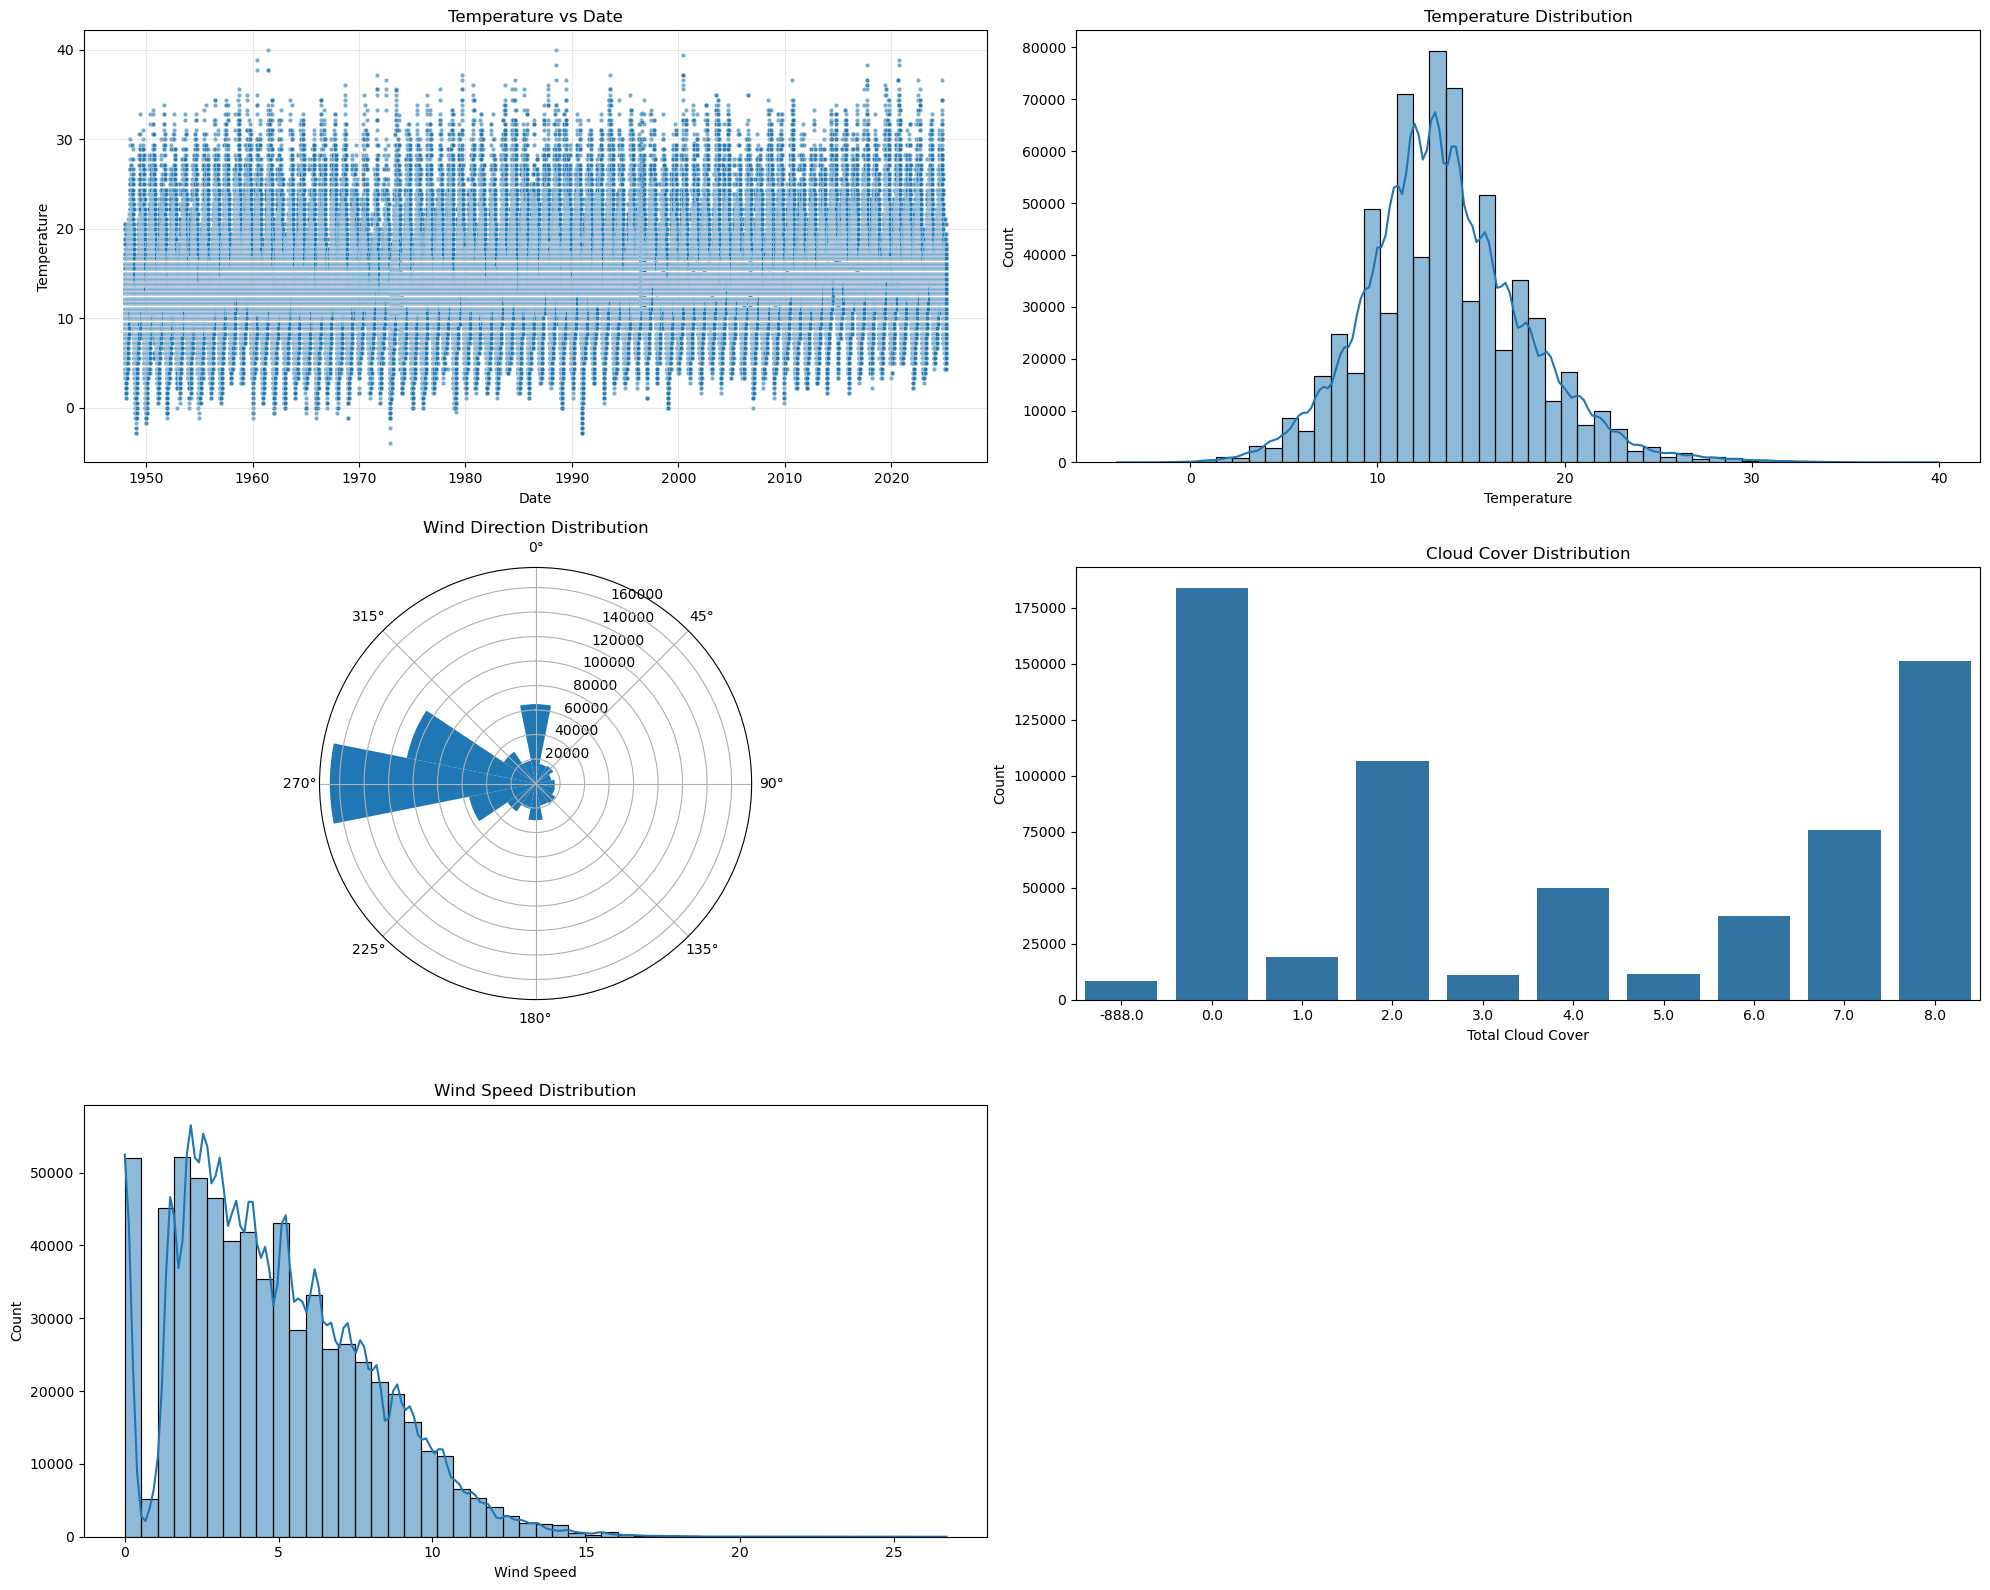

In [15]:
plot_weather_data(SFO)

Then we perform same process to yearly temperature.

2024
1948
Slope: 0.025861258895061467
Intercept: 12.630760156085483


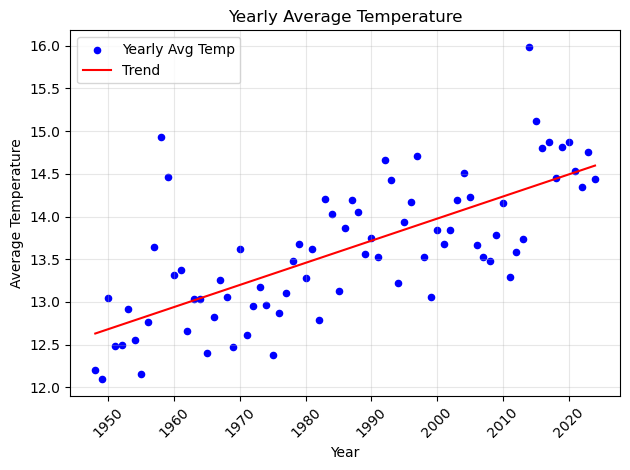

In [16]:
# Filter out extreme temperatures
temp_data_SFO = SFO[SFO['temperatures'] > -100].copy()

# Extract the year from 'time'
temp_data_SFO['year'] = pd.to_datetime(temp_data_SFO['time']).dt.year

# Group by year and calculate mean temperature, excluding 2024
yearly_temps_SFO = temp_data_SFO.groupby('year')['temperatures'].mean().reset_index()
yearly_temps_SFO = yearly_temps_SFO[yearly_temps_SFO['year'] != 2025]
print(yearly_temps_SFO['year'].max())
print(yearly_temps_SFO['year'].min())
plot_yearly_temperature_trend(yearly_temps_SFO)